<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/C8IP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [0]:
import pandas as pd

train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0).reset_index(drop=True)
test = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0).reset_index(drop=True)
mod  = test.index % 5
test_add = test.loc[ mod != 0 ,:]
test_50 = test.loc[ mod == 0 ,:]

In [3]:
train.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,100.5,119.2,146.5,31.978,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,99.6,117.9,145.5,31.568,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,100.0,118.8,145.6,31.344,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,100.4,118.6,142.9,31.453,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,100.4,118.1,142.2,32.190,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


# def train,test,features,y_name

In [4]:
features = ['T10','T50','T90','N+A']
y_name = 'C8IP'

#訓練資料 4521 append 200筆
train = train.append(test_add)[features+[y_name]]
#測試資料 50筆
test = test_50[features+[y_name]]

print(train.shape)
print(test.shape)

(4721, 5)
(50, 5)


# describe

In [5]:
train.describe()

,T10,T50,T90,N+A,C8IP
count,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000
mean,95.216280,115.395742,144.440530,40.815614,8.106389
std,11.551752,6.838592,4.683146,8.437211,2.094218
min,47.100000,83.000000,121.500000,20.570000,0.566000
25%,91.900000,113.000000,142.500000,33.133000,6.385000
50%,99.000000,117.500000,144.500000,38.282000,8.260000
75%,103.700000,119.900000,146.400000,48.938000,10.090000
max,116.900000,131.700000,198.500000,69.540000,19.006000


# corr

In [6]:
train.corr()

,T10,T50,T90,N+A,C8IP
T10,1.000000,0.895238,0.222087,-0.262210,0.713103
T50,0.895238,1.000000,0.533778,-0.371996,0.680072
T90,0.222087,0.533778,1.000000,-0.217989,0.126878
N+A,-0.262210,-0.371996,-0.217989,1.000000,-0.718989
C8IP,0.713103,0.680072,0.126878,-0.718989,1.000000


# kde

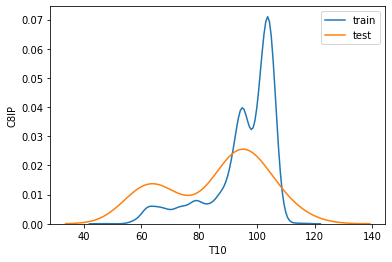

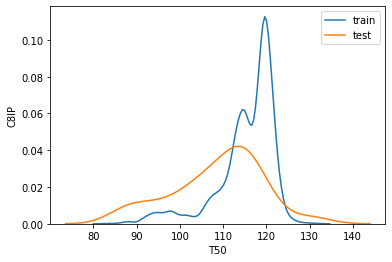

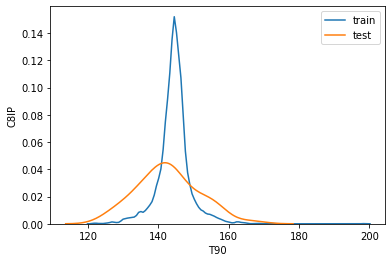

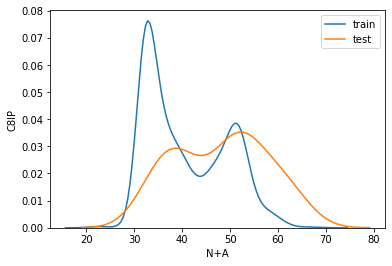

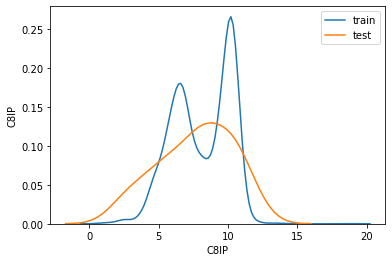

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in features+[y_name]:
  sns.kdeplot(data = train[col],label='train')
  sns.kdeplot(data = test[col],label='test')
  plt.legend();plt.xlabel(col);plt.ylabel(y_name)
  plt.show()

# scatter

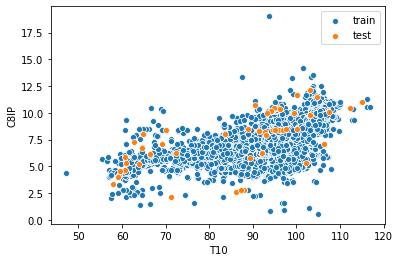

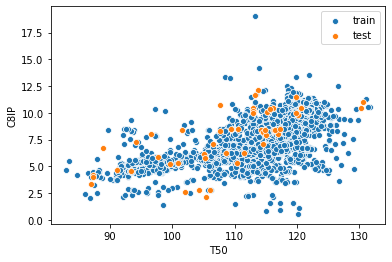

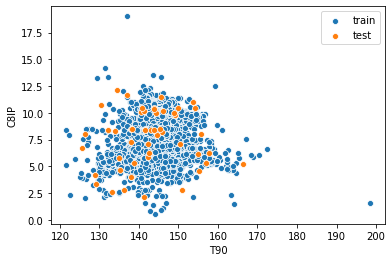

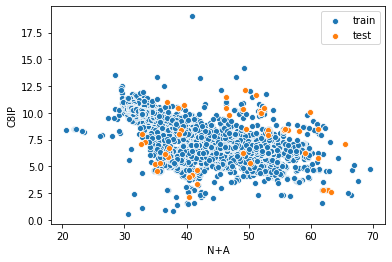

In [8]:
for x_col in features:
  sns.scatterplot(x=x_col,y=y_name,data=train,label='train')
  sns.scatterplot(x=x_col,y=y_name,data=test,label='test')
  plt.legend()
  plt.show()

# pca

基礎關係是線性即可做PCA

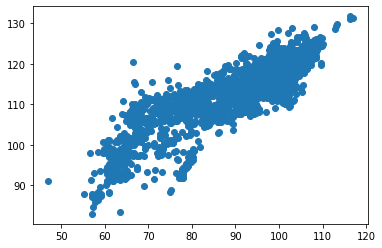

In [9]:
#證明基礎關係是線性
plt.scatter(train['T10'],train['T50'])

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pca = PCA(n_components=1)

train['PCA'] = pca.fit_transform(scaler.fit_transform(train[['T10','T50']]))
test['PCA'] = pca.transform(scaler.transform(test[['T10','T50']]))

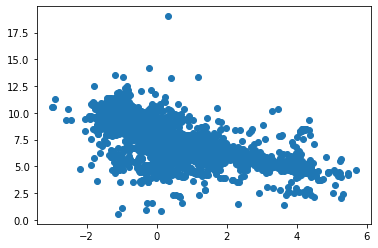

In [11]:
plt.scatter(train['PCA'],train[y_name])

# isomap

重點1: 只要基礎關係是非線性的， Isomap優於PCA！

重點2: 請務必對所有因子使用特徵縮放，因為如果不這樣做，Isomap基於最近鄰搜索將會很差

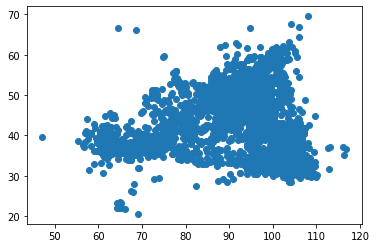

In [12]:
# 首先來證明基礎關係是非線性的
plt.scatter(train['T10'],train['N+A'])

In [0]:
from sklearn.manifold import isomap
from sklearn.preprocessing import StandardScaler

iso = isomap.Isomap(n_components=1)
scaler = StandardScaler()

train['ISO'] = iso.fit_transform(scaler.fit_transform(train[['T10','N+A']]))
test['ISO'] = iso.transform(scaler.transform(test[['T10','N+A']]))

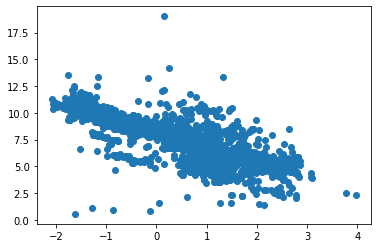

In [14]:
plt.scatter(train['ISO'],train[y_name])

In [15]:
abs(train.corr())[[y_name]].sort_values(by=y_name,ascending=False)

,C8IP
C8IP,1.000000
ISO,0.893312
N+A,0.718989
PCA,0.715581
T10,0.713103
T50,0.680072
T90,0.126878


# features select

In [0]:
features = ['ISO']

# features scaler

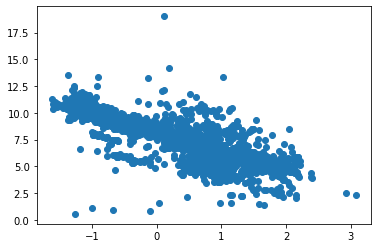

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train[features])

train[features] = scaler.transform(train[features])
test[features] = scaler.transform(test[features])

plt.scatter(train[features],train[y_name])

# metric

In [0]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt
def metric(y_t,y_p):
  res = {'R2':r2_score(y_t,y_p),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'mean_absolute_error':mean_absolute_error(y_t,y_p)}
  return pd.DataFrame(res,index=[y_t.name])

# modeling

In [19]:
import xgboost
from sklearn.svm import SVR
from math import sqrt
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import warnings 
warnings.simplefilter('ignore')

#model = DecisionTreeRegressor(max_depth=1)
#model = xgboost.XGBRegressor(objective='reg:squarederror')
#model = SVR()
model = LinearRegression()

val_scores = cross_validate(model,train[features],train[y_name],cv=5)

print('val_scores:',val_scores['test_score'])
print('val_scores.mean:',val_scores['test_score'].mean())

# fit 
model.fit(train[features],train[y_name])
# predict
test['y_pred'] = model.predict(test[features])
train['y_pred'] = model.predict(train[features])

val_scores: [0.78236647 0.81115644 0.83866853 0.88490458 0.57627398]
val_scores.mean: 0.7786739977582194


In [20]:
print('train_scores:')
metric(train[y_name],train['y_pred'])

train_scores:


,R2,RMSE,mean_absolute_error
C8IP,0.798007,0.941118,0.548528


In [21]:
print('test_scores:')
metric(test[y_name],test['y_pred'])

test_scores:


,R2,RMSE,mean_absolute_error
C8IP,0.233266,2.305207,1.981716


# line plot

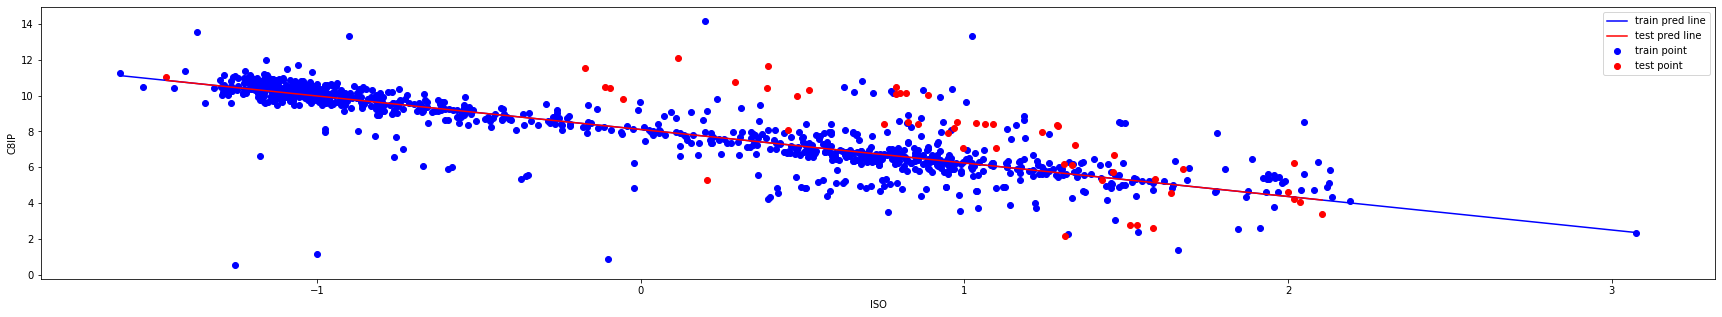

In [22]:
by_col = 'ISO'
fig = plt.figure(figsize=(30,5))
test_point = test.sort_values(by = by_col)
train_sample_point = train.sample(1000).sort_values(by = by_col)

plt.plot(train_sample_point[by_col],train_sample_point['y_pred'],label='train pred line',color='blue')
plt.scatter(train_sample_point[by_col],train_sample_point[y_name],label='train point',color='blue')

plt.plot(test_point[by_col],test_point['y_pred'],label='test pred line',color='red')
plt.scatter(test_point[by_col],test_point[y_name],label='test point',color='red')

plt.xlabel(by_col)
plt.ylabel(y_name)
plt.legend()
plt.show()

# check out

In [23]:
loss = (test_point[y_name] - test_point['y_pred'])**2 # 平方誤差
loss = loss.sort_values(ascending=False)
loss.head(5)

240    18.120278
230    17.811982
120    14.674754
125    12.869068
130    12.734462
dtype: float64

# del out

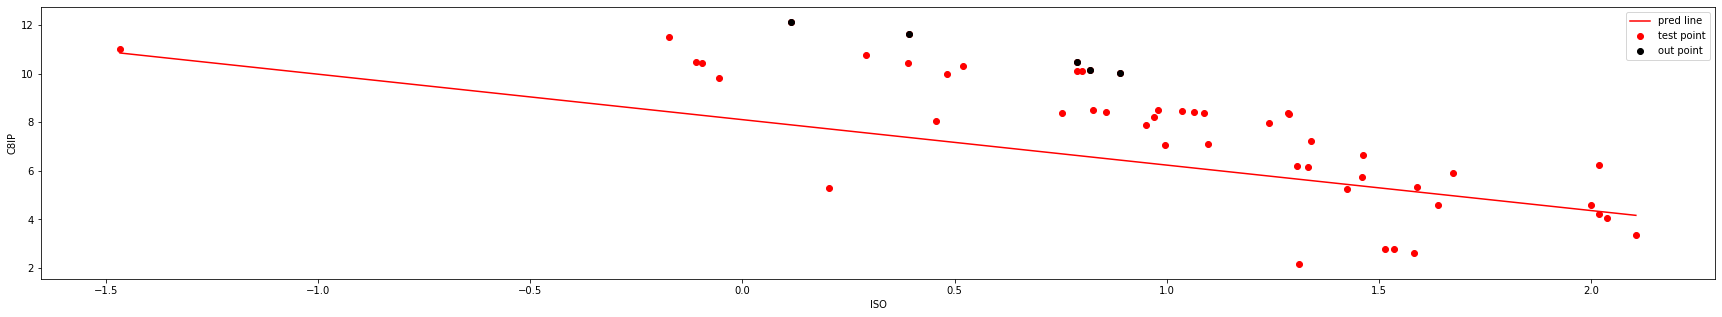

In [24]:
import numpy as np

#add out columns
test_point['out'] = False
test_point.loc[loss.head(5).index,'out'] = True

#fig
fig = plt.figure(figsize=(30,5))

#sort test point
test_point = test_point.sort_values(by=by_col)

#def out_point
out_point = test_point[test_point['out'] == True]

#y_pred line
plt.plot(test_point[by_col],test_point['y_pred'],label='pred line',color='red')

#test point
plt.scatter(test_point[by_col],test_point[y_name],label='test point',color='red')

#out point
plt.scatter(out_point[by_col],out_point[y_name],label='out point',color='black')

plt.xlabel(by_col)
plt.ylabel(y_name)
plt.legend()
plt.show()

# del_out_point_scores:

In [25]:
print('del_out_point_scores:')
metric(test_point.loc[test_point['out'] == False ,y_name],test_point.loc[test_point['out'] == False ,'y_pred'])

del_out_point_scores:


,R2,RMSE,mean_absolute_error
C8IP,0.335948,2.052037,1.769376


# dump model

In [26]:
from sklearn.externals import joblib

joblib.dump(model, 'model.pkl')

['model.pkl']